In [1]:
%matplotlib inline


# K-Fold cross-validation with blocks

Cross-validation scores for spatial data can be biased because observations are
commonly spatially autocorrelated (closer data points have similar values). One
strategy to reduce the bias is to split data along spatial blocks
[Roberts_etal2017]_. Verde offers the cross-validator
:class:`verde.BlockKFold`, which is a scikit-learn compatible version of k-fold
cross-validation using spatial blocks.

When splitting the data into training and testing sets,
:class:`~verde.BlockKFold` first splits the data into spatial blocks and then
splits the blocks into folds. During k-fold cross-validation, one fold is used
as the testing set while the rest are used for training. Since each block can
have a different number of data points, assigning the same number of blocks to
each fold can lead to folds with very different numbers of data points.
By default, :class:`~verde.BlockKFold` takes care to balance the folds to have
approximately equal number of data points.
Alternatively, you can turn off balancing to have each fold contain the same
number of blocks.

This example shows the data assigned to each of the first 3 folds of a blocked
k-fold iteration, with and without balancing. Notice that the unbalanced folds
have very different numbers of data points.


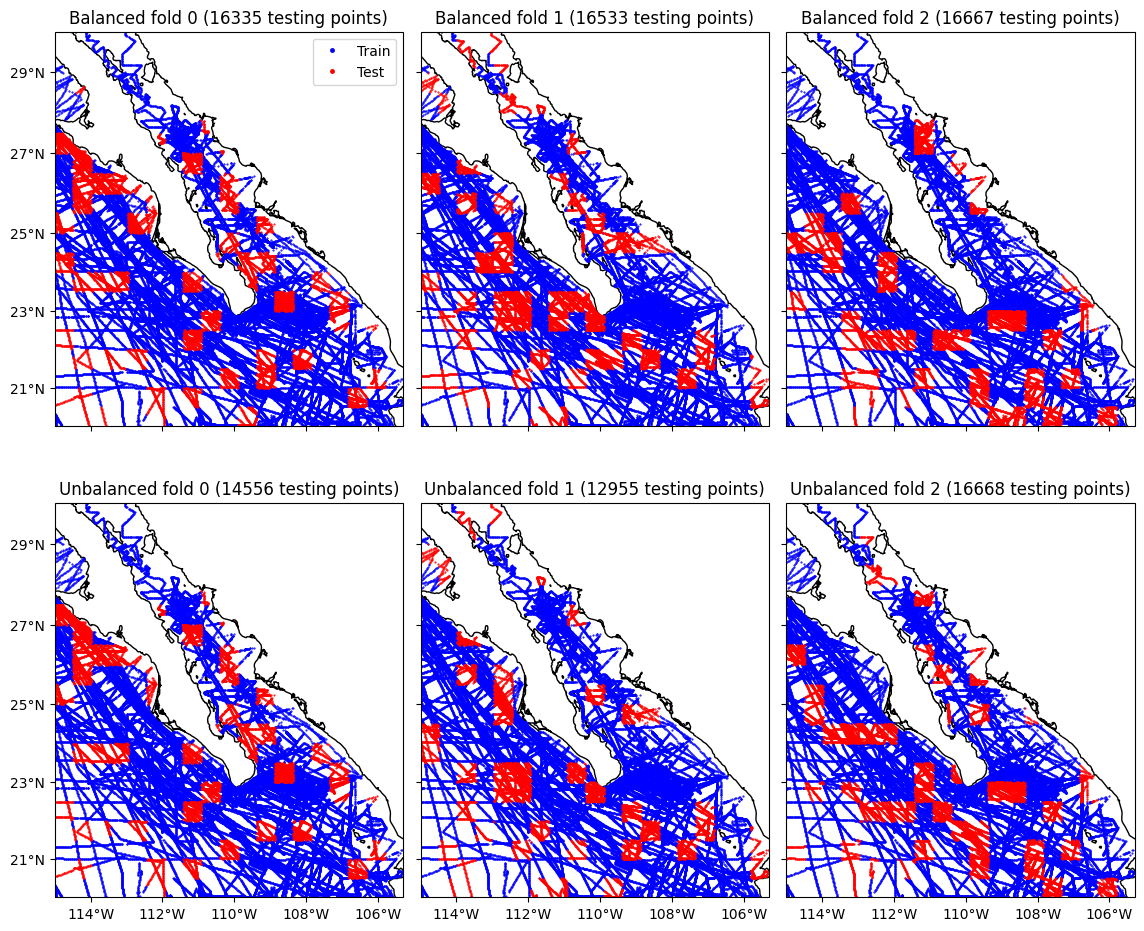

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import verde as vd

# Baja California bathymetry (water-depth) data
data = vd.datasets.fetch_baja_bathymetry()
coordinates = (data.longitude, data.latitude)

spacing = 30 / 60
random_state = 10
kfold = vd.BlockKFold(spacing=spacing, shuffle=True, random_state=random_state)
# Make another cross-validator with fold balancing turned off. Without
# balancing, the folds can have very different number of data points in them
kfold_unbalanced = vd.BlockKFold(
    spacing=spacing,
    shuffle=True,
    random_state=random_state,
    balance=False,
)

#Each column will have one of the coordinate values
feature_matrix = np.transpose(coordinates)

# Create the folds for the balanced and unbalanced cross-validators
balanced = kfold.split(feature_matrix)
unbalanced = kfold_unbalanced.split(feature_matrix)

# Cartopy requires setting the coordinate reference system (CRS) of the
# original data through the transform argument.
crs = ccrs.PlateCarree()

# Make Mercator maps of the two cross-validator folds
fig, axes = plt.subplots(
    2,
    3,
    figsize=(12, 10),
    subplot_kw=dict(projection=ccrs.Mercator()),
    sharex=True,
    sharey=True,
)
for row, title, folds in zip(axes, ["Balanced", "Unbalanced"], [balanced, unbalanced]):
    for i, (ax, fold) in enumerate(zip(row, folds)):
        train, test = fold
        ax.set_title("{} fold {} ({} testing points)".format(title, i, test.size))
        # Use an utility function to setup the tick labels and the land feature
        vd.datasets.setup_baja_bathymetry_map(ax)
        ax.plot(
            coordinates[0][train],
            coordinates[1][train],
            ".b",
            markersize=1,
            transform=crs,
            label="Train",
        )
        ax.plot(
            coordinates[0][test],
            coordinates[1][test],
            ".r",
            markersize=1,
            transform=crs,
            label="Test",
        )
# Place a legend on the first plot
axes[0, 0].legend(loc="upper right", markerscale=5)
plt.subplots_adjust(
    hspace=0.1, wspace=0.05, top=0.95, bottom=0.05, left=0.05, right=0.95
)
plt.show()